# Ampicillin biochemistry - specific activity

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/ampicillin_biochemistry'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

AMP_SHEETNAME = 'biochem_amp_raw'

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
def add_repnum_manuscriptname(row):
    '''
    add the manuscript name and and replicate name from the name used
    in the raw data into the melted dataframe
    '''
    name_repnum = row['variable']
    row['rep_num'] = int(name_repnum[-1])
    row['sample_id'] = name_repnum[0:-3]
    return row

#load data
narrow_df = pd.concat([
    
    pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=AMP_SHEETNAME
    ).iloc[0:28,].melt(['TIME']),

    pd.read_excel(
        FHS.get_data_filename(),
        sheet_name=AMP_SHEETNAME, 
        header=32
    ).iloc[:,:4].melt(['TIME'])

]).reset_index().apply(
    lambda row: add_repnum_manuscriptname(row), 
    axis=1
).drop(['index', 'variable'], axis=1)

narrow_df = FHS.add_manuscript_name_to_df(
    narrow_df, 
    synonym_column='sample_id',
    new_column='manuscript_name'
).drop(['sample_id'], axis=1)

#remove non-existant samples from sample order
sample_order = FHS.get_sample_order(narrow_df.manuscript_name)

## Data Analysis

In [5]:
##############################################################
### Sliding window linear regression and rmsd calculation ####
##############################################################

def calculate_rmsd(slope, intersect, actual_x_values, actual_y_values):
    '''
    calculate the rmsd between predicted values (linear regression) and actual values
    '''
    predicted_values = []
    for actual_x in actual_x_values:
        predicted_values.append(
            slope * actual_x + intersect
        )
    return np.sqrt(
        np.sum(
            (np.array(predicted_values) - np.array(actual_y_values)) ** 2
        ) / len(predicted_values)
    )

def window_linear_regression(narrow_df, window_size=5):
    '''
    repeately perform a linear regression on each design over the number
    of timepoints specified by 'window_size'.
    '''
    #load molecular weights of each design
    # using https://www.bioinformatics.org/sms/prot_mw.html
    molecular_weights = {
        'WT TEM-1': 28.91,
        '50.a': 28.34, '50.b': 27.11,
        '70.a': 28.25, '70.b': 27.87,
        '80.a': 28.34, '80.b': 28.36,
        '90.a': 28.86, '90.b': 28.49,
        '95.a': 28.63, '95.b': 28.71,
        '98.a': 28.77, '98.b': 28.62,
        'rw-consensus': 27.98,
        'opt.b': 28.48,
        'opt.a': 28.73,
        'neg. ctrl': 28.89,
        'pbs': 28.91 #SET TO WT
    }
    for design in molecular_weights.keys():
        molecular_weights[design] *= 1000

    lin_reg_data = []

    for manuscript_name in np.unique(narrow_df.manuscript_name):
        for rep_num in [1,2,3]:
            conditions = narrow_df[
                (narrow_df.manuscript_name == manuscript_name) & 
                (narrow_df.rep_num == rep_num)
            ].sort_values(by='TIME', ascending=True)

            for i in range(0, len(conditions)-window_size):
                window_times = conditions[i:i+window_size].TIME.tolist()
                window_absorbances = conditions[i:i+window_size].value.tolist()
                res = linregress(window_times, window_absorbances)
                design = np.unique(conditions.manuscript_name)[0]
                rep_num = np.unique(conditions.rep_num)[0]
                value = {
                    'manuscript_name': design,
                    'rep_num': rep_num,
                    'start_time_index': i,
                    'start_time_sec': window_times[0],
                    'end_time_sec': window_times[len(window_times)-1],
                    'slope': res.slope,
                    'intercept': res.intercept,
                    'window_times': pd.array(window_times),
                    'window_absorbances': pd.array(window_absorbances),
                    'rmsd': calculate_rmsd(
                        res.slope, res.intercept, 
                        pd.array(window_times), 
                        pd.array(window_absorbances)
                    ),
                    'molecular_weight': molecular_weights[design]
                }
                lin_reg_data.append(value)
    toreturn = pd.DataFrame.from_dict(lin_reg_data)
    return toreturn


def get_best_slopes_df(df, rmsd_cutoff):
    tmpdf = df[df.rmsd <= rmsd_cutoff].reset_index(drop=True)
    return tmpdf.loc[tmpdf.groupby(['manuscript_name', 'rep_num']).slope.idxmin()].reset_index(drop=True)


In [6]:
#Perform a linear regression of size 5 across every timepoint
amp_lr_win5_df = window_linear_regression(narrow_df, window_size=5)

## Data quality

<Axes: xlabel='rmsd', ylabel='Count'>

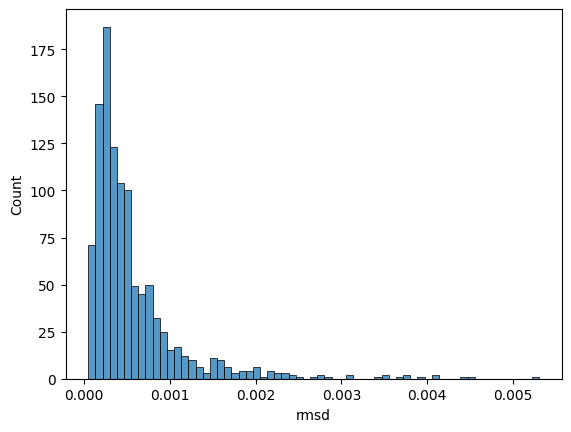

In [7]:
sns.histplot(amp_lr_win5_df, x='rmsd')

## Plot fit of linear regression to data

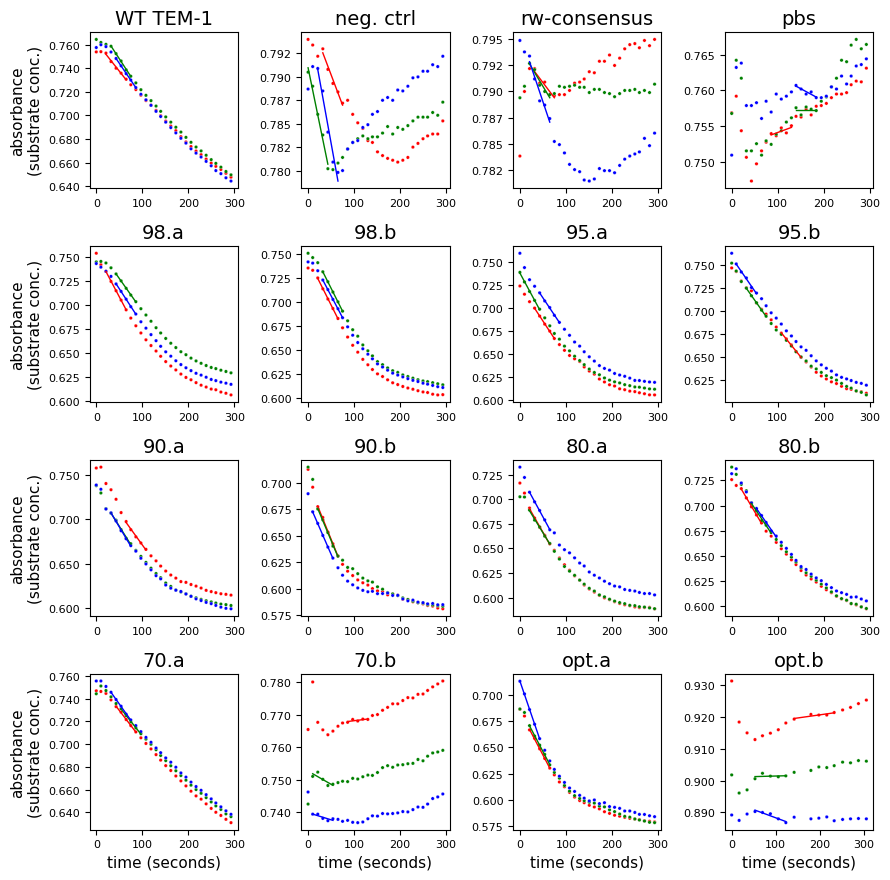

In [8]:
def plot_data_fit(rawdata_df, linregress_df):
    colors = { 1: 'red', 2: 'green', 3: 'blue' }
    
    num_cols = 4
    fig, axes = plt.subplots(nrows=4, ncols=num_cols)
    fig.set_size_inches(9, 9)
    axes = axes.flatten()

    top_slopes_df = get_best_slopes_df(linregress_df, rmsd_cutoff=0.001)
    
    for idx, manuscript_name in enumerate(sample_order):
        plotting_df = narrow_df[narrow_df.manuscript_name==manuscript_name]
        ax = axes[idx]
        
        sns.scatterplot(
            plotting_df, x='TIME', y='value', 
            hue='rep_num', palette=colors,
            s=6, edgecolors=None,
            ax=ax
        )

        #plot linear regression
        for rep_num in [1,2,3]:
            line = top_slopes_df[(
                (top_slopes_df.manuscript_name==manuscript_name) &
                (top_slopes_df.rep_num==rep_num)
            )]
            x = np.array(list(line.window_times)).flatten()
            y = list(line.slope)[0] * x + list(line.intercept)
            ax.plot(
                x, y, linewidth=1, color=colors[rep_num], 
                #label='linear regression with max slope (replicate {0})'.format(rep_num)
            )
            
        ax.yaxis.set_major_formatter('{x:.3f}')
        
        ax.set_title(manuscript_name, fontsize=14)
        ax.xaxis.set_tick_params(labelsize=8)
        ax.yaxis.set_tick_params(labelsize=8)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        if idx > 11:
            ax.set_xlabel('time (seconds)', fontsize=11)
        if idx % num_cols == 0:
            ax.set_ylabel('absorbance\n(substrate conc.)', fontsize=11)
        ax.get_legend().remove()
        
    fig.tight_layout(rect=[0, 0.00, 1, 0.99])
    fig.savefig(OUTPUT_DIR+'/ampicillin_data_fit_to_lr.pdf')
    
plot_data_fit(narrow_df, amp_lr_win5_df)

#### Output Source Data

In [9]:
def get_datafit_source():
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    return narrow_df.assign(
        manuscript_sort_order = lambda df: df.manuscript_name.apply(
            lambda sample: sample_order.index(sample)
        )  
    ).sort_values(
        by=['manuscript_sort_order', 'rep_num', 'TIME']
    ).reset_index(
        drop=True
    )[[
        'manuscript_name', 'rep_num', 'TIME', 'value'
    ]].rename(columns={
        'manuscript_name': 'Sample',
        'rep_num': 'Rep #',
        'TIME': 'Time (seconds)',
        'value': 'Absorbance (substrate concentration)'
    })
    
get_datafit_source().to_csv(
    OUTPUT_DIR+'/ampicillin_raw_data.tab', sep ='\t', index=False
)

In [10]:
def get_final_slopes_source_data():
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    top_slopes_df = get_best_slopes_df(amp_lr_win5_df, rmsd_cutoff=0.001)
    return top_slopes_df.assign(
        sort_manuscript_order = lambda df: df.manuscript_name.apply(
            lambda samplename: sample_order.index(samplename)
        ),
        window_times_str = lambda df: df.window_times.apply(
            lambda times: ','.join([str(t) for t in times])
        )
    ).sort_values(
        by=['sort_manuscript_order', 'rep_num']
    )[[
        'manuscript_name', 'rep_num', 'slope', 'intercept', 'window_times_str'
    ]].rename(columns={
        'manuscript_name': 'Sample',
        'rep_num': 'Rep #',
        'slope': 'Slope',
        'intercept': 'Intercept',
        'window_times_str': 'Initial Rate Window Times (seconds)'
    })
get_final_slopes_source_data().to_csv(
    OUTPUT_DIR+'/ampicillin_final_slopes.tab', sep ='\t', index=False
)

## Plot final specific activity

In [11]:
def smart_jitter(bp, df, ax, 
                 actual_sample_order,
                 sample_colname='manuscript_name', 
                 na_samples=[],
                 rep_colname='rep_num',
                 value_colname='specific_activity'):
    #plot raw datapoints, but "smart" jitter so all are visible
    #bp = barplot output
    rawdatapoints = {'x':[], 'y': []}
    for idx, samplename in enumerate(actual_sample_order):
        bar_details = bp.patches[idx]
        padding = 0.2 * bar_details.get_width()
        bar_x_start = bar_details.xy[0] + padding
        bar_width = bar_details.get_width() - (2 * padding)

        rep_spacing = 1 / 2 * bar_width
        if samplename in na_samples:
            ax.text(
                x=bar_x_start+(bar_width/2), y=40,
                horizontalalignment='center', verticalalignment='center',
                s='N/A', fontsize=14
            )
        else:
            tmp_df = df[df[sample_colname]==samplename]
            for i in range(0, 3):
                rawdatapoints['x'].append(bar_x_start + (i * rep_spacing))
                tmp_df = df[(
                    (df[sample_colname]==samplename) &
                    (df[rep_colname]==i+1)
                )]
                rawdatapoints['y'].append(tmp_df[value_colname])
        
    ax.scatter(
        x=rawdatapoints['x'], y=rawdatapoints['y'], 
        color='darkred', s=20, zorder=10,
        marker='D', linewidth=0
    )

def plotSpecificActivity(df_linear_fit, rmsd_cutoff=0.001):
    '''
    Final plot of the specific activity. Activity assay is absorbance. 
       Starting enzyme 0.5 nanomolar:
          - enzyme molecular weight, e.g., 28.91 kilodaltons (WT) and 28.25 (70.1)
          - 1 dalton = 1 g / mol so 28910 and 28250 grams per mol
          - starting enzyme is 0.5 nanomolar in 0.1 mL = (5e-10 * 100e-6)
          - (5e-10 * 100e-6) mol * X grams/mol = mass in grams
          - mass in grams * 1000 = mass in milligrams
    '''
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7.186)

    best_fit_slopes_df = get_best_slopes_df(df_linear_fit, rmsd_cutoff)
    best_fit_slopes_df = best_fit_slopes_df[best_fit_slopes_df.manuscript_name != 'pbs']
    
    #don't need to keep pbs for main figure and we do need the 50s. hardcode
    sample_order_wopbs_w50s = [
        'WT TEM-1', 'neg. ctrl', 'rw-consensus',
        '98.a', '98.b', '95.a', '95.b', '90.a', '90.b',
        '80.a', '80.b', '70.a', '70.b', '50.a', '50.b', 'opt.a', 'opt.b'
    ]
    
    # calculate specific activity => change in absorbance per milligram enzyme per second 
    #   change in absorbance: calculate using slope from linear model of initial velocity and the
    #                         same timeframe of measurement of inital velocity. multiple the slope
    #                         by -1 to invert as absorbance measures substrate not product.
    #               (there are only marginal differences vs using measured absorbances directly)
    #   mg enzyme: 0.5 nM = 5e-10 M 
    #                    in 100 uL => 100e-6 L
    #       = 5e-10 * 100e-6 * molecular_weight(g/mol) * 1000 mg/g
    #   time: timeframe of measurement of inital velocity (same as delta absorbance determination)
    best_fit_slopes_df = best_fit_slopes_df.assign(
        start_absorbance_fit = lambda df: df.apply(
            lambda r: r.slope * r.start_time_sec + r.intercept,
            axis='columns'
        ),
        
        end_absorbance_fit = lambda df: df.apply(
            lambda r: r.slope * r.end_time_sec + r.intercept,
            axis='columns'
        ),
        
        specific_activity = lambda df: df.apply(
            lambda r: (
                -(
                    #
                    # total absorbance change - calculated from initial velocity fit
                    #
                    r.end_absorbance_fit - r.start_absorbance_fit
                ) / (
                    #
                    # mg of enzyme
                    #
                    5e-10 *  # enzyme concentraion in molar (0.5 nM)
                    100e-6 * # volume of reaction (100 uL)
                    r.molecular_weight * #molecular weight of each enzyme in daltons
                    1000 #convert grams to milligrams
                ) / (
                    #
                    # time in seconds
                    #
                    r.end_time_sec - r.start_time_sec
                )
            ),
            axis='columns'
        )
    )
    
    
    #add 50's even though they aren't there - will indicate N/A in plot
    best_fit_slopes_df = pd.concat([best_fit_slopes_df, pd.DataFrame(
        {
            'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b',],
            'rep_num': [1, 2, 3, 1, 2, 3],
            'specific_activity': [0, 0, 0, 0, 0, 0]
        }
    )]).reset_index()

    bp = sns.barplot(
        data=best_fit_slopes_df, x='manuscript_name', y='specific_activity',
        errorbar='sd', color='lightgray', order=sample_order_wopbs_w50s
    )

    smart_jitter(bp, best_fit_slopes_df, ax, sample_order_wopbs_w50s, na_samples=['50.a', '50.b'])
    ax.set_title('Biochemistry of Ampicillin Hydrolysis', fontsize=20)
    ax.set_ylabel('Specific Activity\n(change in absorbance per mg enzyme per second)')
    ax.set_xlabel('Design')
    ax.set_ylim([
        -30, ax.get_ylim()[1]
    ])
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, 
                       ha='right', rotation_mode='anchor')
    
    #save figure
    fig.savefig(OUTPUT_DIR+'/amp_biochem_specificactivity.pdf')

    #save the top slopes that are used in the main figure to a csv
    best_fit_slopes_df.to_csv(OUTPUT_DIR+'/processed_amp_specific_activity_data.tab', sep='\t')
    return best_fit_slopes_df

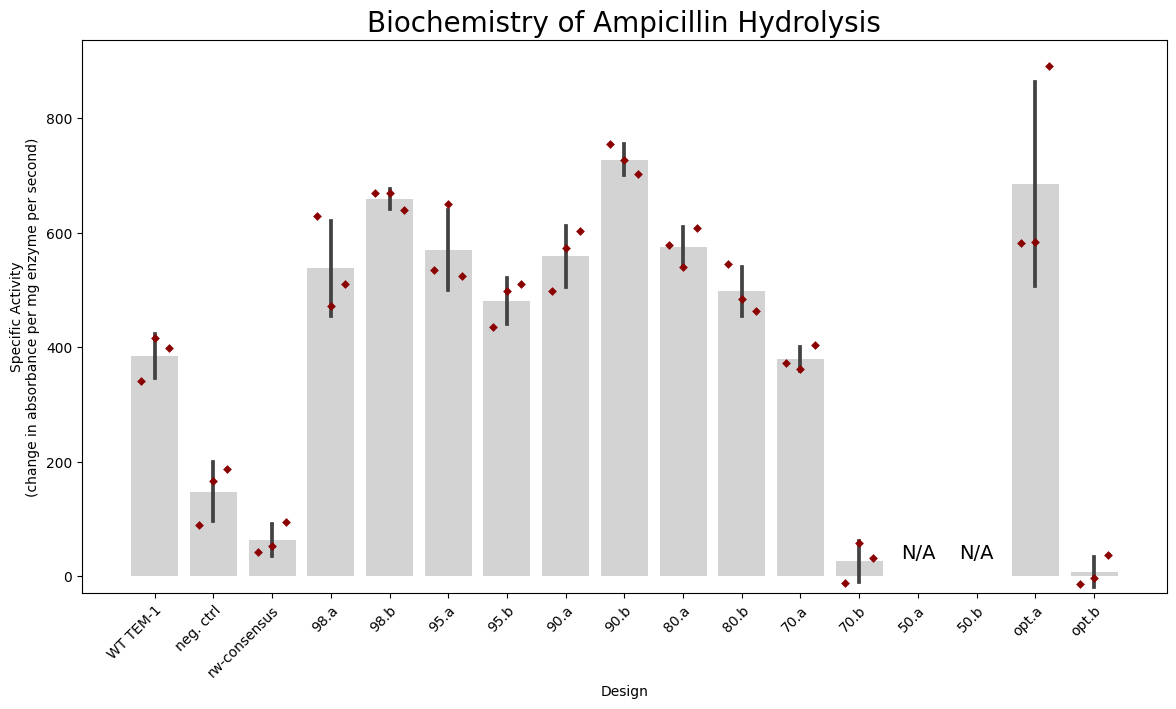

In [12]:
plotted_df = plotSpecificActivity(amp_lr_win5_df, rmsd_cutoff=0.001)

#### Output Source Data

In [13]:
def get_specificactivity_source():
    sample_order = FHS.get_sample_order(plotted_df.manuscript_name)
    return plotted_df.assign(
        manuscript_sort_order = lambda df: df.manuscript_name.apply(
            lambda sample: sample_order.index(sample)
        )  
    ).sort_values(
        by=['manuscript_sort_order', 'rep_num', 'specific_activity']
    ).reset_index(
        drop=True
    )[[
        'manuscript_name', 'rep_num', 'specific_activity'
    ]].rename(columns={
        'manuscript_name': 'Sample',
        'rep_num': 'Rep #',
        'specific_activity': 'Specific Activity'
    })
    
get_specificactivity_source().to_csv(
    OUTPUT_DIR+'/ampicillin_specific_activity.tab', sep ='\t', index=False
)